In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from polyglot.text import Text

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

nltk.download('punkt')
nltk.download('stopwords')
spacy_data = spacy.load("xx_sent_ud_sm")
import xx_sent_ud_sm
spacy_nlp = xx_sent_ud_sm.load()


[nltk_data] Downloading package punkt to /Users/merturhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/merturhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Loading the dataset
dataset = pd.read_csv('train.csv')

In [4]:
# Display the dataset
print(dataset)

                                                  content  score  upvotes
0                                               Çox qəşəy      5        0
1       Men niye nomre ile qeydiyatdan kece bilmirem.....      1        0
2       Salam. Mən yukluyə bilmirəm. Necə kömək edə bi...      5        0
3                                               cox gözəl      5        1
4       Xaiş edirem bu problemi hell edinde həftədə 2 ...      5        0
...                                                   ...    ...      ...
127532           Cox pisdi 24 saat 50 deyqə nedir ki güya      1        0
127533                     Super çox sağ olun minnətdaram      5        0
127534  Azərbaycanda belə proqramların olması çox yaxş...      5        0
127535  Bu gün çox pis xidmət etdiniz. Ona görə boltda...      1        1
127536  Əla proqramdır. Amma hələ ki bəzi funksiyalar ...      4       11

[127537 rows x 3 columns]


In [5]:
import re

# Emoji Cleaner Regex
def remove_emojis(text):
    if text is None:  # Check if the text is None
        return None
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zğüşıöçəĞÜŞİÖÇƏ ]', '', text)  # Keep Azerbaijani Turkish letters and whitespace
    return text if text.strip() != '' else None  # Return None if text is empty

# Define the stopwords removal function
def remove_stopwords(text):
    if text is None:  # Check if the text is None
        return None
    words = text.split()
    turkish_stopwords = stopwords.words('turkish')
    filtered_text = ' '.join([word for word in words if word not in turkish_stopwords])
    return filtered_text if filtered_text.strip() != '' else None  # Return None if filtered text is empty



# Clear emojis and make all lowercased
dataset['content'] = dataset['content'].apply(lambda x: remove_emojis(str(x)).lower())
# Filter rows where 'content' column contains Turkish or Azerbaijani characters, 
dataset = dataset[dataset['content'].apply(lambda x: bool(clean_text(x)))]


# Reset index after filtering
dataset.reset_index(drop=True, inplace=True)



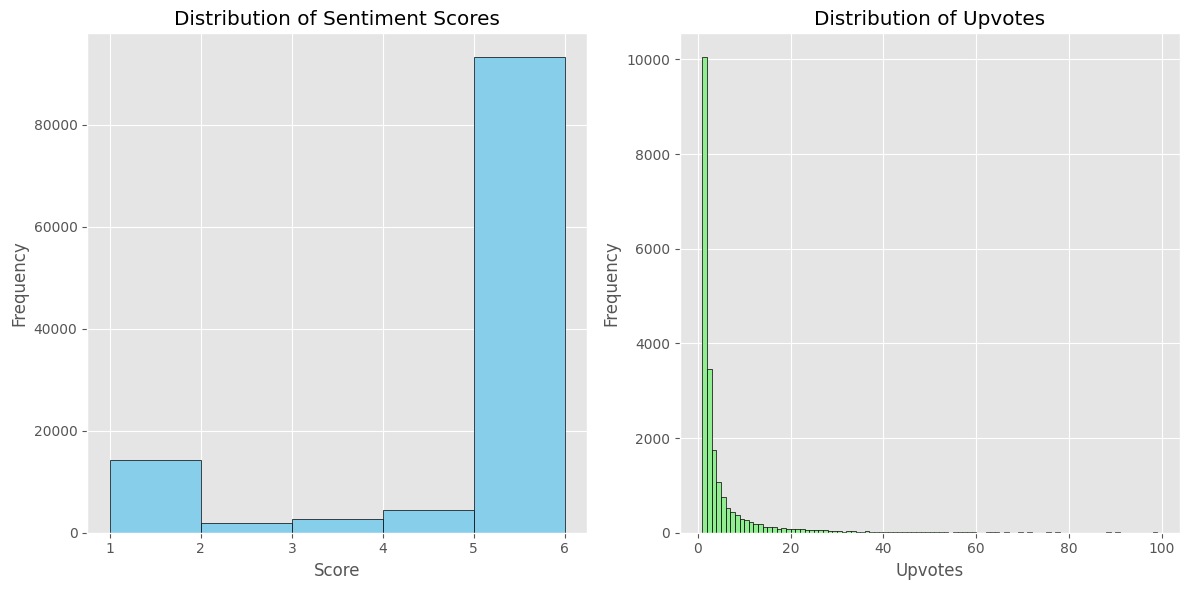

In [6]:
# Seperating contents, scores and upvotes
contents = dataset['content'].values.tolist()
scores = dataset['score'].values.tolist()
upvotes = dataset['upvotes'].values.tolist()

# Setting the style
plt.style.use('ggplot')

# Creating a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotting histogram for 'score'
axes[0].hist(scores, bins=range(1, 7), edgecolor='black', color='skyblue')
axes[0].set_title('Distribution of Sentiment Scores')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Plotting histogram for 'upvotes'
axes[1].hist(upvotes, bins=range(1, 100), edgecolor='black', color='lightgreen')
axes[1].set_title('Distribution of Upvotes')
axes[1].set_xlabel('Upvotes')
axes[1].set_ylabel('Frequency')

# Tight layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

/var/folders/wn/nnxn2_tj63sd570s6m72ctjh0000gn/T/ipykernel_4779/1334611829.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_upvotes_means.index, y=score_upvotes_means.values, palette='viridis')


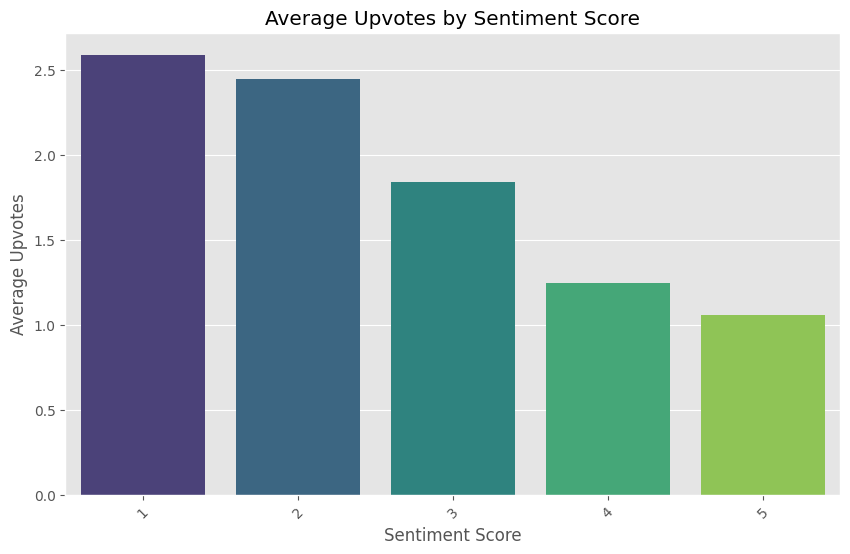

In [7]:
score_upvotes_means = dataset.groupby('score')['upvotes'].mean()

# Çubuk grafiği oluşturma
plt.figure(figsize=(10, 6))
sns.barplot(x=score_upvotes_means.index, y=score_upvotes_means.values, palette='viridis')
plt.title('Average Upvotes by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Average Upvotes')
plt.xticks(rotation=45)
plt.show()

In [8]:
pipeline = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean_text))),
    ('stopwords_remover', FunctionTransformer(lambda x: x.apply(remove_stopwords))),
    ('cleaner_emojies', FunctionTransformer(lambda x: x.apply(remove_emojis)))  # Adding vectorizer to convert text into a numeric format
])

# Assuming 'dataset' is your DataFrame and it contains the 'content' column
processed_data = pipeline.fit_transform(dataset['content'])

# Filter out None values and split the data
# 'processed_data' is a sparse matrix, need to convert dataset['score'] accordingly
valid_indices = [i for i, text in enumerate(dataset['content']) if text is not None]
X = processed_data[valid_indices]  # Filter the processed data
y = dataset['score'].iloc[valid_indices]  # Filter the target variable accordingly

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (93190,)
Testing set shape: (23298,)


In [9]:
def tokenize_text_spacy(text):
    if text is None:
        return None
    doc = spacy_nlp(text)
    return [token.text for token in doc]

# Eğitim ve test verilerini tokenleme ve None değerleri filtreleme
X_train_tokenized = X_train.apply(lambda x: tokenize_text_spacy(x) if x is not None else None)
X_test_tokenized = X_test.apply(lambda x: tokenize_text_spacy(x) if x is not None else None)

# None değerlerini filtreleyerek saf veri setlerini elde et
X_train_filtered = X_train_tokenized[X_train_tokenized.notnull()]
y_train_filtered = y_train[X_train_tokenized.notnull()]
X_test_filtered = X_test_tokenized[X_test_tokenized.notnull()]
y_test_filtered = y_test[X_test_tokenized.notnull()]

# İlk birkaç tokenleşmiş örnekleri göster
print("Tokenized Training Data Examples:", X_train_filtered.head())
print("Tokenized Test Data Examples:", X_test_filtered.head())

Tokenized Training Data Examples: 20596                                              [super]
49180                                            [könüllü]
61537                                           [mükəmməl]
62462                                                [əla]
80571    [çox, yaxşı, mən, kodla, azn, endirim, aldım, ...
Name: content, dtype: object
Tokenized Test Data Examples: 8619     [elektron, karti, yazim, playmarketden, yukley...
2442     [cox, gözel, di, hamya, tövsüye, edrem, superd...
58111                                         [bmw, aldim]
91771               [istifadəçi, kodunu, necə, əldə, edək]
72942    [zibil, kimi, işləyir, həm, gec, həmdə, praqra...
Name: content, dtype: object


Tokenized Training Data Examples: 20596                                              [super]
49180                                            [könüllü]
61537                                           [mükəmməl]
62462                                                [əla]
80571    [çox, yaxşı, mən, kodla, azn, endirim, aldım, ...
Name: content, dtype: object
Tokenized Test Data Examples: 8619     [elektron, karti, yazim, playmarketden, yukley...
2442     [cox, gözel, di, hamya, tövsüye, edrem, superd...
58111                                         [bmw, aldim]
91771               [istifadəçi, kodunu, necə, əldə, edək]
72942    [zibil, kimi, işləyir, həm, gec, həmdə, praqra...
Name: content, dtype: object
Epoch 1/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.7879 - loss: 0.8575 - val_accuracy: 0.8012 - val_loss: 0.7137
Epoch 2/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 58s 160ms/step - accuracy: 0.7998 - loss: 0.7145 - val_accuracy: 0.8012 - val_loss: 0.7133
Epoch 3/5
364/364 ━━━━━━━━━━

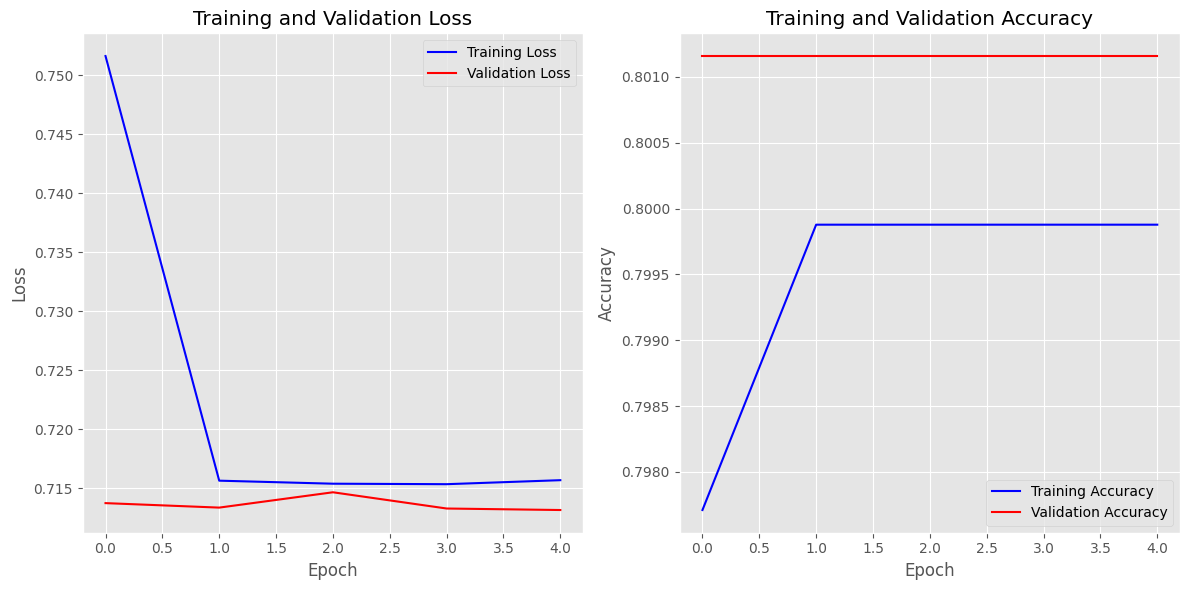

In [10]:
def tokenize_text_nltk(text):
    if text is None:
        return None
    return word_tokenize(text, language='turkish')

# Eğitim ve test verilerini tokenleme ve None değerleri filtreleme
X_train_tokenized = X_train.apply(lambda x: tokenize_text_nltk(x) if x is not None else None)
X_test_tokenized = X_test.apply(lambda x: tokenize_text_nltk(x) if x is not None else None)

# None değerlerini filtreleyerek saf veri setlerini elde et
X_train_filtered = X_train_tokenized[X_train_tokenized.notnull()]
y_train_filtered = y_train[X_train_tokenized.notnull()]
X_test_filtered = X_test_tokenized[X_test_tokenized.notnull()]
y_test_filtered = y_test[X_test_tokenized.notnull()]

# İlk birkaç tokenleşmiş örnekleri göster
print("Tokenized Training Data Examples:", X_train_filtered.head())
print("Tokenized Test Data Examples:", X_test_filtered.head())

# Tokenizer'ı oluştur
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_filtered)

# Tokenizer'ı kullanarak eğitim ve test verilerini dönüştür
X_train_sequences = tokenizer.texts_to_sequences(X_train_filtered)
X_test_sequences = tokenizer.texts_to_sequences(X_test_filtered)

# Eğitim ve test verilerini sabit bir uzunluğa doldur
X_train_padded = pad_sequences(X_train_sequences, padding='post')
X_test_padded = pad_sequences(X_test_sequences, padding='post', maxlen=X_train_padded.shape[1])

# Tokenizer'ın kelime indekslerini ve kelime sayısını al
word_index = tokenizer.word_index
num_words = len(word_index) + 1

# Eğitim ve test verilerini ve etiketlerini TensorFlow veri setlerine dönüştür
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train_filtered))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_padded, y_test_filtered))

# Batch ve karıştırma işlemlerini uygula
batch_size = 256
train_dataset = train_dataset.shuffle(len(X_train_padded)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Modeli oluştur
model = Sequential([
    Embedding(num_words, 32),
    GRU(32),
    Dense(6, activation='softmax')
])

# Modeli derle
model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Modeli eğit
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

# Eğitim ve doğrulama kayıplarını ve doğruluklarını çiz
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
def tokenize_text_polyglot(text, language_code='tr'):
    if text is None:
        return None
    try:
        polyglot_text = Text(text, hint_language_code=language_code)
        return [token for token in polyglot_text.words]
    except Exception as e:
        print(f"Error during tokenization: {e}")
        return None

X_train_tokenized = X_train.apply(lambda x: tokenize_text_polyglot(x) if x is not None else None)
X_test_tokenized = X_test.apply(lambda x: tokenize_text_polyglot(x) if x is not None else None)

# None değerlerini filtreleyerek saf veri setlerini elde et
X_train_filtered = X_train_tokenized[X_train_tokenized.notnull()]
y_train_filtered = y_train[X_train_tokenized.notnull()]
X_test_filtered = X_test_tokenized[X_test_tokenized.notnull()]
y_test_filtered = y_test[X_test_tokenized.notnull()]

# İlk birkaç tokenleşmiş örnekleri göster
print("Tokenized Training Data Examples:", X_train_filtered.head())
print("Tokenized Test Data Examples:", X_test_filtered.head())

Tokenized Training Data Examples: 20596                                              [super]
49180                                            [könüllü]
61537                                           [mükəmməl]
62462                                                [əla]
80571    [çox, yaxşı, mən, kodla, azn, endirim, aldım, ...
Name: content, dtype: object
Tokenized Test Data Examples: 8619     [elektron, karti, yazim, playmarketden, yukley...
2442     [cox, gözel, di, hamya, tövsüye, edrem, superd...
58111                                         [bmw, aldim]
91771               [istifadəçi, kodunu, necə, əldə, edək]
72942    [zibil, kimi, işləyir, həm, gec, həmdə, praqra...
Name: content, dtype: object
